In [2]:
%pip install casadi

Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import casadi as ca


U = ca.MX.sym('U', 10, 2)
print(U[0,:].shape)

(1, 2)


In [ ]:
from utils import lissajous

print(lissajous(10))

[1.618033988749895, 1.902113032590307, -2.1358682644473594]


In [ ]:
import numpy as np

In [ ]:
a = np.array([[1,0],[0,1],[1,1]])
b = np.array([2,3])
print(np.dot(a,b))

[2 3 5]


In [ ]:
import casadi as ca

def G(dt,e,ref,u):
    g = ca.array([[dt*ca.cos(e[2]+ref[2]),0],[dt*ca.sin(e[2]+ref[2]),0],[0,dt]])
    return e + ca.mtimes(g,u)

In [ ]:
import numpy as np

u = ca.MX([1,2])
v = ca.MX([3,4])

print(np.sqrt((u[0]-v[0])**2)>0)

(0<fabs(([1, 2][0]-[3, 4][0])))


In [ ]:
import casadi as ca
import numpy as np
import utils

class CEC:
    def __init__(self, T=10, dt=0.1, gamma=0.9, Q=np.eye(2), q=1.0, R=np.eye(2)) -> None:
        self.T = T
        self.dt = dt
        self.gamma = gamma
        self.Q = Q
        self.q = q
        self.R = R
        self.obs1 = [-2,-2,0.5]
        self.obs2 = [1,2,0.5]

    def __call__(self, t: int, cur_state: np.ndarray, cur_ref_state: np.ndarray) -> np.ndarray:
        """
        Given the time step, current state, and reference state, return the control input.
        Args:
            t (int): time step
            cur_state (np.ndarray): current state
            cur_ref_state (np.ndarray): reference state
        Returns:
            np.ndarray: control input
        """
        # TODO: define optimization variables
        U = ca.MX.sym('U', self.T, 2)
        print(U[1,:].T.shape)
        # TODO: define optimization constraints and optimization objective
        
        Xk = cur_state
        ek = ca.MX(cur_state - cur_ref_state)
        objective = self.cost_function(ek,U[0,:],0)
        
        constraints = []

        for k in range(1,self.T+1):
            Uk = U[k-1,:]
            Xk_next = utils.car_next_state_casadi(self.dt, Xk, Uk.T) 
            ref_next = utils.lissajous(t+k)
            ek_next = Xk_next - ref_next
            objective += self.cost_function(ek_next, Uk, k)
            # constraints.append(ek_next == self.G(self.dt,ek,cur_ref_state,Uk))  # This stores the propagated state
            Xk = Xk_next
            ek = ek_next


        # TODO: define optimization solver
        nlp = {'x': ca.reshape(U,-1,1), 'f': objective, 'g': ca.vertcat(*constraints)}
        solver = ca.nlpsol("S", "ipopt", nlp)
        sol = solver(
            x0=ca.DM(np.zeros(2 * self.T)),  # TODO: initial guess
            lbx=ca.DM(np.tile([utils.v_min, utils.w_min], self.T)), # TODO: lower bound on optimization variables
            ubx=ca.DM(np.tile([utils.v_max, utils.w_max], self.T)), # TODO: upper bound on optimization variables
            lbg=ca.DM(np.zeros(3 * self.T)), # TODO: lower bound on optimization constraints
            ubg=ca.DM(np.zeros(3 * self.T)), # TODO: upper bound on optimization constraints
        )
        x = sol["x"]  # get the solution

        # TODO: extract the control input from the solution
        u = np.array(x[0:2,:])
        return u
    
    # def cost_function(self, x, u, k):
    #     p_cost = ca.mtimes([x[0:2].T, self.Q, x[0:2]])
    #     theta_cost = self.q * (1 - ca.cos(x[2]))**2
    #     u_cost = ca.mtimes([u, self.R, u.T])
    #     return self.gamma**k*(p_cost + theta_cost + u_cost)

    def cost_function(self, x, u, k):
        p_cost = x[0:2].T @ self.Q @ x[0:2]
        theta_cost = self.q * (1 - np.cos(x[2]))**2
        u_cost = u @ self.R @ u.T
        return self.gamma**k*(p_cost + theta_cost + u_cost)
    
    def G(self, dt, e, ref, u):
        g = ca.vertcat(
            ca.horzcat(dt * ca.cos(e[2] + ref[2]), 0),
            ca.horzcat(dt * ca.sin(e[2] + ref[2]), 0),
            ca.horzcat(0, dt)
        )
        return e + ca.mtimes(g, u.T)
    
    def collision_check(self, x):
        if (ca.norm_2(x,self.obs1[:2]) < self.obs1[2]) or (ca.norm_2(x,self.obs2[:2]) < self.obs2[2]):
            return True
        else:
            return False
        
    


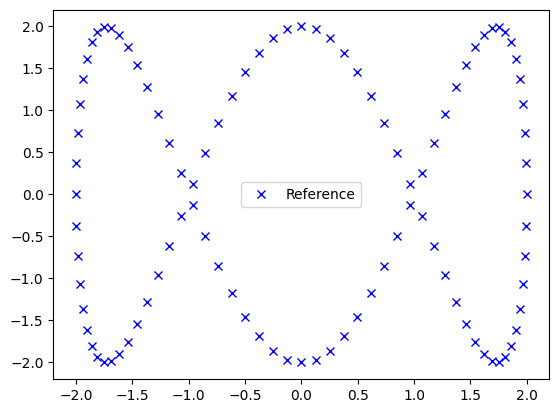

In [ ]:
from utils import lissajous
import matplotlib.pyplot as plt

ref_traj = np.array([lissajous(t) for t in range(100)])

plt.figure()
plt.plot(ref_traj[:, 0], ref_traj[:, 1], 'bx', label='Reference')
# plt.plot(car_states[:, 0], car_states[:, 1], 'k-', label='Actual Path')
plt.legend()
plt.show()

In [ ]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [ ]:
from dataclasses import dataclass
import numpy as np
from value_function import ValueFunction
import utils
import ray


@dataclass
class GpiConfig:
    traj: callable
    obstacles: np.ndarray
    ex_space: np.ndarray
    ey_space: np.ndarray
    eth_space: np.ndarray
    v_space: np.ndarray
    w_space: np.ndarray
    Q: np.ndarray
    q: float
    R: np.ndarray
    gamma: float
    num_evals: int  # number of policy evaluations in each iteration
    collision_margin: float
    V: ValueFunction  # your value function implementation
    output_dir: str
    # used by feature-based value function
    v_ex_space: np.ndarray
    v_ey_space: np.ndarray
    v_etheta_space: np.ndarray
    v_alpha: float
    v_beta_t: float
    v_beta_e: float
    v_lr: float
    v_batch_size: int  # batch size if GPU memory is not enough


class GPI:
    def __init__(self, config: GpiConfig):
        self.config = config
        # TODO: other initialization code

    def __call__(self, t: int, cur_state: np.ndarray, cur_ref_state: np.ndarray) -> np.ndarray:
        """
        Given the time step, current state, and reference state, return the control input.
        Args:
            t (int): time step
            cur_state (np.ndarray): current state
            cur_ref_state (np.ndarray): reference state
        Returns:
            np.ndarray: control input
        """
        # TODO: your implementation
        raise NotImplementedError

    def state_metric_to_index(self, metric_state: np.ndarray) -> tuple:
        """
        Convert the metric state to grid indices according to your descretization design.
        Args:
            metric_state (np.ndarray): metric state
        Returns:
            tuple: grid indices
        """
        # TODO: your implementation
        raise NotImplementedError

    def state_index_to_metric(self, state_index: tuple) -> np.ndarray:
        """
        Convert the grid indices to metric state according to your descretization design.
        Args:
            state_index (tuple): grid indices
        Returns:
            np.ndarray: metric state
        """
        # TODO: your implementation
        raise NotImplementedError

    def control_metric_to_index(self, control_metric: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Args:
            control_metric: [2, N] array of controls in metric space
        Returns:
            [N, ] array of indices in the control space
        """
        v: np.ndarray = np.digitize(control_metric[0], self.config.v_space, right=True)
        w: np.ndarray = np.digitize(control_metric[1], self.config.w_space, right=True)
        return v, w

    def control_index_to_metric(self, v: np.ndarray, w: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Args:
            v: [N, ] array of indices in the v space
            w: [N, ] array of indices in the w space
        Returns:
            [2, N] array of controls in metric space
        """
        return self.config.v_space[v], self.config.w_space[w]

    def compute_transition_matrix(self):
        """
        Compute the transition matrix in advance to speed up the GPI algorithm.
        """
        # TODO: your implementation
        raise NotImplementedError

    def compute_stage_costs(self):
        """
        Compute the stage costs in advance to speed up the GPI algorithm.
        """
        # TODO: your implementation
        raise NotImplementedError

    def init_value_function(self):
        """
        Initialize the value function.
        """
        # TODO: your implementation
        raise NotImplementedError

    def evaluate_value_function(self):
        """
        Evaluate the value function. Implement this function if you are using a feature-based value function.
        """
        # TODO: your implementation
        raise NotImplementedError

    @utils.timer
    def policy_improvement(self):
        """
        Policy improvement step of the GPI algorithm.
        """
        # TODO: your implementation
        raise NotImplementedError

    @utils.timer
    def policy_evaluation(self):
        """
        Policy evaluation step of the GPI algorithm.
        """
        # TODO: your implementation
        raise NotImplementedError

    def compute_policy(self, num_iters: int) -> None:
        """
        Compute the policy for a given number of iterations.
        Args:
            num_iters (int): number of iterations
        """
        # TODO: your implementation
        raise NotImplementedError
        



In [ ]:
import numpy as np


class ValueFunction:
    def __init__(self, T: int, ex_space, ey_space, etheta_space):
        self.T = T
        self.ex_space = ex_space
        self.ey_space = ey_space
        self.etheta_space = etheta_space

    def copy_from(self, other):
        """
        Update the underlying value function storage with another value function
        """
        # TODO: your implementation
        raise NotImplementedError

    def update(self, t, ex, ey, etheta, target_value):
        """
        Update the value function at given states
        Args:
            t: time step
            ex: x position error
            ey: y position error
            etheta: theta error
            target_value: target value
        """
        # TODO: your implementation
        raise NotImplementedError

    def __call__(self, t, ex, ey, etheta):
        """
        Get the value function results at given states
        Args:
            t: time step
            ex: x position error
            ey: y position error
            etheta: theta error
        Returns:
            value function results
        """
        # TODO: your implementation
        raise NotImplementedError

    def copy(self):
        """
        Create a copy of the value function
        Returns:
            a copy of the value function
        """
        # TODO: your implementation
        raise NotImplementedError


class GridValueFunction(ValueFunction):
    """
    Grid-based value function
    """
    # TODO: your implementation
    raise NotImplementedError


class FeatureValueFunction(ValueFunction):
    """
    Feature-based value function
    """
    # TODO: your implementation
    raise NotImplementedError




In [ ]:
import os
from utils import lissajous
import ray
import numpy as np  

ex_space=np.linspace(-3, 3, 19),  # Example discretization, change as needed
ey_space=np.linspace(-3, 3, 19),
eth_space=np.linspace(-np.pi, np.pi, 19),
v_space=np.linspace(0, 1, 6),  # Example control space, change as needed
w_space=np.linspace(-1, 1, 11)


def compute_neighbors_and_probabilities(next_state_mean):
    std = np.array([0.04, 0.04, 0.004])
    offsets = np.array([[-1, -1, 0], [-1, 0, 0], [-1, 1, 0],
                        [0, -1, 0], [0, 1, 0],
                        [1, -1, 0], [1, 0, 0], [1, 1, 0]])
    neighbors = next_state_mean + offsets

    probabilities = gaussian_likelihood(neighbors, next_state_mean, std)
    probabilities /= probabilities.sum()

    return np.hstack((neighbors, probabilities[:, np.newaxis]))

def gaussian_likelihood(x, mean, std):
    # Handle multiple rows in x
    return np.exp(-0.5 * np.sum(((x - mean) / std) ** 2, axis=1)) / (np.sqrt(2 * np.pi) * np.prod(std))


def compute_next_state_mean(e, ref_cur,ref_next, u, dt=0.1):
    # Create the g matrix
    g = np.array([
        [dt * np.cos(e[2] + ref_cur[2]), 0],
        [dt * np.sin(e[2] + ref_cur[2]), 0],
        [0, dt]
    ])
    
    # Calculate the new state
    return e + np.dot(g, u.T) + np.array(ref_cur) - np.array(ref_next)


def compute_transition_matrix():
        """
        Compute the transition matrix in advance to speed up the GPI algorithm.
        """
        nt, nx, ny, ntheta = 100, 19, 19, 19
        nv, nw = 6, 11

        @ray.remote
        def worker(start, end):
            local_matrix = np.empty((end-start, nx, ny, ntheta, nv, nw, 8, 4), dtype=np.float32)
            for t in range(end-start):
                ref_cur = lissajous(t)
                ref_next = lissajous(t + 1)
                for ex in range(nx):
                    for ey in range(ny):
                        for eth in range(ntheta):
                            for v in range(nv):
                                for w in range(nw):
                                    state = np.array([ex_space[0][ex], ey_space[0][ey], eth_space[0][eth]])
                                    print(state)
                                    control = np.array([v_space[0][v], w_space[w]])
                                    print(control)
                                    next_state_mean = compute_next_state_mean(state,ref_cur,ref_next, control)
                                    print(next_state_mean)
                                    probabilities = compute_neighbors_and_probabilities(next_state_mean)
                                    print(probabilities)
                                    local_matrix[t, ex, ey, eth, v, w] = probabilities
            return local_matrix

        num_workers = 32
        jobs = []
        for i in range(num_workers):
            start = i * (nt // num_workers)
            end = (i + 1) * (nt // num_workers)
            jobs.append(worker.remote(start, end))

        results = ray.get(jobs)
        ray.shutdown()

        transition_matrix = np.empty((nt, nx, ny, ntheta, nv, nw, 8, 4), dtype=np.float32)
        for j in range(num_workers):
            start = j * (nt // num_workers)
            end = (j + 1) * (nt // num_workers)
            print(results[j].shape)
            transition_matrix[start:end] = results[j]


transition_matrix_file = '/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/transition_matrix_f32.npy'  # Specify the file path to save the array

if not os.path.exists(transition_matrix_file):
    with open(transition_matrix_file, 'w') as file:
        pass

transition_matrix = compute_transition_matrix()
np.save(transition_matrix_file, transition_matrix)  # Save the array to the file

In [1]:
import os
from utils import lissajous
import ray
import numpy as np  

ex_space=np.linspace(-3, 3, 21),  # Example discretization, change as needed
ey_space=np.linspace(-3, 3, 21),
eth_space=np.linspace(-np.pi, np.pi, 40),
v_space=np.linspace(0, 1, 6),  # Example control space, change as needed
w_space=np.linspace(-1, 1, 11)


def compute_neighbors_and_probabilities(next_state_mean):
    std = np.array([0.04, 0.04, 0.004])
    offsets = np.array([[-1, -1, 0], [-1, 0, 0], [-1, 1, 0],
                        [0, -1, 0], [0, 1, 0],
                        [1, -1, 0], [1, 0, 0], [1, 1, 0]])
    neighbors = next_state_mean + offsets

    probabilities = gaussian_likelihood(neighbors, next_state_mean, std)
    probabilities /= probabilities.sum()

    return np.hstack((neighbors, probabilities[:, np.newaxis]))

def gaussian_likelihood(x, mean, std):
    # Handle multiple rows in x
    return np.exp(-0.5 * np.sum(((x - mean) / std) ** 2, axis=1)) / (np.sqrt(2 * np.pi) * np.prod(std))


def compute_next_state_mean(e, ref_cur,ref_next, u, dt=0.1):
    # Create the g matrix
    g = np.array([
        [dt * np.cos(e[2] + ref_cur[2]), 0],
        [dt * np.sin(e[2] + ref_cur[2]), 0],
        [0, dt]
    ])
    
    # Calculate the new state
    return e + np.dot(g, u.T) + np.array(ref_cur) - np.array(ref_next)


def compute_transition_matrix():
    """
    Compute the transition matrix in advance to speed up the GPI algorithm.
    """
    nt, nx, ny, ntheta = 100, 21, 21, 40
    nv, nw = 6, 11

    @ray.remote
    def worker(start, end):
        local_matrix = np.empty((end-start, nx, ny, ntheta, nv, nw, 8, 4), dtype=np.float16)

        t_indices = np.arange(start, end)
        ex_indices = np.arange(nx)
        ey_indices = np.arange(ny)
        eth_indices = np.arange(ntheta)
        v_indices = np.arange(nv)
        w_indices = np.arange(nw)

        ex_space_arr = ex_space[0][ex_indices]
        ey_space_arr = ey_space[0][ey_indices]
        eth_space_arr = eth_space[0][eth_indices]
        v_space_arr = v_space[0][v_indices]
        w_space_arr = w_space[w_indices]

        for t in range(end-start):
            ref_cur = lissajous(t)
            ref_next = lissajous(t + 1)
            
            error_states = np.array(np.meshgrid(ex_space_arr, ey_space_arr, eth_space_arr)).T.reshape(-1, 3)
            controls = np.array(np.meshgrid(v_space_arr, w_space_arr)).T.reshape(-1, 2)

            for error_state in error_states:
                next_state_means = np.array([compute_next_state_mean(error_state, ref_cur, ref_next, control) for control in controls])
                neighbors_and_probs = np.array([compute_neighbors_and_probabilities(next_state_mean) for next_state_mean in next_state_means])

                idx_e = np.where((error_states == error_state).all(axis=1))[0][0]
                ex, ey, eth = np.unravel_index(idx_e, (nx, ny, ntheta))

                for idx_c, control in enumerate(controls):
                    v, w = np.unravel_index(idx_c, (nv, nw))
                    local_matrix[t, ex, ey, eth, v, w] = neighbors_and_probs[idx_c]

        return local_matrix

    num_workers = 32
    jobs = []
    for i in range(num_workers):
        start = i * (nt // num_workers)
        end = (i + 1) * (nt // num_workers)
        jobs.append(worker.remote(start, end))

    results = ray.get(jobs)
    ray.shutdown()

    transition_matrix = np.empty((nt, nx, ny, ntheta, nv, nw, 8, 4), dtype=np.float16)
    for j in range(num_workers):
        start = j * (nt // num_workers)
        end = (j + 1) * (nt // num_workers)
        # print(results[j])
        transition_matrix[start:end] = results[j]


    return transition_matrix


transition_matrix_file = '/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/transition_matrix_f16.npy'  # Specify the file path to save the array

if not os.path.exists(transition_matrix_file):
    with open(transition_matrix_file, 'w') as file:
        pass

transition_matrix = compute_transition_matrix()
np.save(transition_matrix_file, transition_matrix)  # Save the array to the file

2024-06-13 21:17:46,296	INFO worker.py:1753 -- Started a local Ray instance.


In [1]:
import os
from utils import lissajous
import ray
import numpy as np  

ex_space=np.linspace(-3, 3, 21),  # Example discretization, change as needed
ey_space=np.linspace(-3, 3, 21),
eth_space=np.linspace(-np.pi, np.pi, 40),
v_space=np.linspace(0, 1, 6),  # Example control space, change as needed
w_space=np.linspace(-1, 1, 11)

Q = np.eye(2)
q = 1.0
R = np.eye(2)

def compute_stage_cost(error_state, control):
    p_error = error_state[:2]
    theta_error = error_state[2]
    return p_error.T @ Q @ p_error + q * (1 - np.cos(theta_error)) ** 2 + control.T @ R @ control

def compute_stage_costs():
    """
    Compute the stage costs in advance to speed up the GPI algorithm.
    """
    nt, nx, ny, ntheta = 100, 21, 21, 40
    nv, nw = 6, 11

    @ray.remote
    def worker(start, end):
        local_costs = np.empty((end-start, nx, ny, ntheta, nv, nw))
        for t in range(end-start):
            for ex in range(nx):
                for ey in range(ny):
                    for eth in range(ntheta):
                        for v in range(nv):
                            for w in range(nw):
                                error_state = np.array([ex_space[0][ex], ey_space[0][ey], eth_space[0][eth]])
                                control = np.array([v_space[0][v],w_space[w]])
                                local_costs[t, ex, ey, eth, v, w] = compute_stage_cost(error_state, control)
        return local_costs

    num_workers = 32
    jobs = []
    for i in range(num_workers):
        start = i * (nt // num_workers)
        end = (i + 1) * (nt // num_workers)
        jobs.append(worker.remote(start, end))

    results = ray.get(jobs)
    ray.shutdown()

    stage_costs = np.empty((nt, nx, ny, ntheta, nv, nw), dtype=np.float16)
    for j in range(num_workers):
        start = j * (nt // num_workers)
        end = (j + 1) * (nt // num_workers)
        stage_costs[start:end] = results[j]

    return stage_costs

stage_cost_file = '/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/stage_cost_f16.npy'  # Specify the file path to save the array

if not os.path.exists(stage_cost_file):
    with open(stage_cost_file, 'w') as file:
        pass

stage_cost = compute_stage_costs()
np.save(stage_cost_file, stage_cost)

2024-06-13 21:23:56,117	INFO worker.py:1753 -- Started a local Ray instance.


In [4]:
import numpy as np

transition_matrix = np.load('/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/transition_matrix_f16.npy', allow_pickle=True)
stage_costs = np.load('/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/stage_cost_f16.npy', allow_pickle=True)

print("Transition matrix shape:", transition_matrix.shape)
print("Stage costs shape:", stage_costs.shape)


Transition matrix shape: (100, 21, 21, 40, 6, 11, 8, 4)
Stage costs shape: (100, 21, 21, 40, 6, 11)


In [ ]:
from dataclasses import dataclass
import numpy as np
from value_function import ValueFunction
import utils
import ray


@dataclass
class GpiConfig:
    traj: callable
    obstacles: np.ndarray
    ex_space: np.ndarray
    ey_space: np.ndarray
    eth_space: np.ndarray
    v_space: np.ndarray
    w_space: np.ndarray
    Q: np.ndarray
    q: float
    R: np.ndarray
    gamma: float
    num_evals: int  # number of policy evaluations in each iteration
    collision_margin: float
    V: ValueFunction  # your value function implementation
    output_dir: str
    # used by feature-based value function
    v_ex_space: np.ndarray
    v_ey_space: np.ndarray
    v_etheta_space: np.ndarray
    v_alpha: float
    v_beta_t: float
    v_beta_e: float
    v_lr: float
    v_batch_size: int  # batch size if GPU memory is not enough


class GPI:
    def __init__(self, config: GpiConfig):
        self.config = config
        self.init_value_function()
        # self.transition_matrix = self.compute_transition_matrix()
        # self.stage_costs = self.compute_stage_costs()
        self.transition_matrix = np.load('/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/transition_matrix_f16.npy',allow_pickle=True)
        self.stage_costs = np.load('/home/mmkr/Documents/ECE276B/ECE276B_PR3/starter_code/stage_cost_f16.npy',allow_pickle=True)
        ray.init(ignore_reinit_error=True)

    def __call__(self, t: int, cur_state: np.ndarray, cur_ref_state: np.ndarray) -> np.ndarray:
        """
        Given the time step, current state, and reference state, return the control input.
        Args:
            t (int): time step
            cur_state (np.ndarray): current state
            cur_ref_state (np.ndarray): reference state
        Returns:
            np.ndarray: control input
        """
        cur_error_state = self.compute_error_state(cur_state, cur_ref_state)
        v, w = self.policy_improvement()
        return np.array([self.config.v_space[v], self.config.w_space[w]])

    def state_metric_to_index(self, metric_state: np.ndarray) -> tuple:
        """
        Convert the metric state to grid indices according to your descretization design.
        Args:
            metric_state (np.ndarray): metric state
        Returns:
            tuple: grid indices
        """
        ex_index = np.digitize(metric_state[0], self.config.ex_space, right=True)
        ey_index = np.digitize(metric_state[1], self.config.ey_space, right=True)
        eth_index = np.digitize(metric_state[2], self.config.eth_space, right=True)
        return ex_index, ey_index, eth_index

    def state_index_to_metric(self, state_index: tuple) -> np.ndarray:
        """
        Convert the grid indices to metric state according to your descretization design.
        Args:
            state_index (tuple): grid indices
        Returns:
            np.ndarray: metric state
        """
        return np.array([self.config.ex_space[state_index[0]], self.config.ey_space[state_index[1]], self.config.eth_space[state_index[2]]])

    def control_metric_to_index(self, control_metric: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Args:
            control_metric: [2, N] array of controls in metric space
        Returns:
            [N, ] array of indices in the control space
        """
        v: np.ndarray = np.digitize(control_metric[0], self.config.v_space, right=True)
        w: np.ndarray = np.digitize(control_metric[1], self.config.w_space, right=True)
        return v, w

    def control_index_to_metric(self, v: np.ndarray, w: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Args:
            v: [N, ] array of indices in the v space
            w: [N, ] array of indices in the w space
        Returns:
            [2, N] array of controls in metric space
        """
        return self.config.v_space[v], self.config.w_space[w]

    # def compute_transition_matrix(self):
    #     """
    #     Compute the transition matrix in advance to speed up the GPI algorithm.
    #     """
    #     nt, nx, ny, ntheta = 100, len(self.config.ex_space), len(self.config.ey_space), len(self.config.eth_space)
    #     nv, nw = len(self.config.v_space), len(self.config.w_space)
    #     transition_matrix = np.zeros((nt, nx, ny, ntheta, nv, nw, 8, 4))

    #     @ray.remote
    #     def worker(start, end):
    #         local_matrix = np.zeros((nt, nx, ny, ntheta, nv, nw, 8, 4))
    #         for t in range(start, end):
    #             for ex in range(nx):
    #                 for ey in range(ny):
    #                     for eth in range(ntheta):
    #                         for v in range(nv):
    #                             for w in range(nw):
    #                                 state = np.array([self.config.ex_space[ex], self.config.ey_space[ey], self.config.eth_space[eth]])
    #                                 control = np.array([self.config.v_space[v], self.config.w_space[w]])
    #                                 next_state_mean = self.compute_next_state_mean(state, control)
    #                                 neighbors = self.get_neighbors(next_state_mean)
    #                                 probabilities = self.compute_transition_probabilities(next_state_mean, neighbors)
    #                                 local_matrix[t, ex, ey, eth, v, w] = neighbors, probabilities
    #         return local_matrix

    #     num_workers = 8
    #     jobs = []
    #     for i in range(num_workers):
    #         start = i * (nt // num_workers)
    #         end = (i + 1) * (nt // num_workers)
    #         jobs.append(worker.remote(start, end))

    #     results = ray.get(jobs)
    #     for result in results:
    #         transition_matrix += result

    #     return transition_matrix

    # def compute_stage_costs(self):
    #     """
    #     Compute the stage costs in advance to speed up the GPI algorithm.
    #     """
    #     nt, nx, ny, ntheta = len(self.config.traj), len(self.config.ex_space), len(self.config.ey_space), len(self.config.eth_space)
    #     nv, nw = len(self.config.v_space), len(self.config.w_space)
    #     stage_costs = np.zeros((nt, nx, ny, ntheta, nv, nw))

    #     @ray.remote
    #     def worker(start, end):
    #         local_costs = np.zeros((nt, nx, ny, ntheta, nv, nw))
    #         for t in range(start, end):
    #             for ex in range(nx):
    #                 for ey in range(ny):
    #                     for eth in range(ntheta):
    #                         for v in range(nv):
    #                             for w in range(nw):
    #                                 error_state = np.array([self.config.ex_space[ex], self.config.ey_space[ey], self.config.eth_space[eth]])
    #                                 control = np.array([self.config.v_space[v], self.config.w_space[w]])
    #                                 local_costs[t, ex, ey, eth, v, w] = self.compute_stage_cost(error_state, control)
    #         return local_costs

    #     num_workers = 8
    #     jobs = []
    #     for i in range(num_workers):
    #         start = i * (nt // num_workers)
    #         end = (i + 1) * (nt // num_workers)
    #         jobs.append(worker.remote(start, end))

    #     results = ray.get(jobs)
    #     for result in results:
    #         stage_costs += result

    #     return stage_costs

    def init_value_function(self):
        """
        Initialize the value function.
        """
        self.value_function = self.config.V

    def evaluate_value_function(self):
        """
        Evaluate the value function. Implement this function if you are using a feature-based value function.
        """
        self.value_function.evaluate()

    # @utils.timer
    # def policy_improvement(self):
    #     """
    #     Policy improvement step of the GPI algorithm.
    #     """
    #     nt, nx, ny, ntheta = 100, len(self.config.ex_space), len(self.config.ey_space), len(self.config.eth_space)
    #     nv, nw = len(self.config.v_space), len(self.config.w_space)
    #     new_policy = np.zeros((nt, nx, ny, ntheta, 2))

    #     for t in range(nt):
    #         for ex in range(nx):
    #             for ey in range(ny):
    #                 for eth in range(ntheta):
    #                     min_cost = float('inf')
    #                     best_control = (0, 0)
    #                     for v in range(nv):
    #                         for w in range(nw):
    #                             cost = self.stage_costs[t, ex, ey, eth, v, w] + \
    #                                    self.config.gamma * np.sum(self.transition_matrix[t, ex, ey, eth, v, w] *
    #                                                               self.value_function.get_value_function())
    #                             if cost < min_cost:
    #                                 min_cost = cost
    #                                 best_control = (v, w)
    #                     new_policy[t, ex, ey, eth] = best_control

    #     return new_policy

    @utils.timer
    def policy_improvement(self):
        """
        Policy improvement step of the GPI algorithm.
        """
        nt, nx, ny, ntheta = 100, len(self.config.ex_space), len(self.config.ey_space), len(self.config.eth_space)
        nv, nw = len(self.config.v_space), len(self.config.w_space)
        new_policy = np.zeros((nt, nx, ny, ntheta, 2))

        value_grid = self.value_function.value_grid  # Access the value_grid directly

        for t in range(nt):
            for ex in range(nx):
                for ey in range(ny):
                    for eth in range(ntheta):
                        min_cost = float('inf')
                        best_control = (0, 0)
                        for v in range(nv):
                            for w in range(nw):
                                cost = self.stage_costs[t, ex, ey, eth, v, w] + \
                                    self.config.gamma * np.sum(self.transition_matrix[t, ex, ey, eth, v, w] *
                                                                value_grid[t])
                                if cost < min_cost:
                                    min_cost = cost
                                    best_control = (v, w)
                        new_policy[t, ex, ey, eth] = best_control

        return new_policy


    @utils.timer
    def policy_evaluation(self):
        """
        Policy evaluation step of the GPI algorithm.
        """
        for _ in range(self.config.num_evals):
            self.evaluate_value_function()

    def compute_policy(self, num_iters: int) -> None:
        """
        Compute the policy for a given number of iterations.
        Args:
            num_iters (int): number of iterations
        """
        for _ in range(num_iters):
            self.policy_evaluation()
            self.policy_improvement()
        

    def compute_next_state_mean(self, state, control):
        delta = 0.1  # Discretization time step
        theta = state[2]
        G = np.array([[delta * np.cos(theta), 0],
                      [delta * np.sin(theta), 0],
                      [0, delta]])
        return state + G @ control

    def get_neighbors(self, next_state_mean):
        """
        Get the neighboring states for the given state.
        """
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                for k in range(-1, 2):
                    if i == 0 and j == 0 and k == 0:
                        continue
                    neighbors.append(next_state_mean + np.array([i, j, k]))
        return neighbors

    def compute_transition_probabilities(self, next_state_mean, neighbors):
        probabilities = []
        for neighbor in neighbors:
            probabilities.append(self.gaussian_likelihood(neighbor, next_state_mean, [0.04, 0.04, 0.004]))
        return np.array(probabilities) / np.sum(probabilities)

    def gaussian_likelihood(self, x, mean, std):
        return np.exp(-0.5 * np.sum(((x - mean) / std) ** 2)) / (np.sqrt(2 * np.pi) * np.prod(std))

    def compute_stage_cost(self, error_state, control):
        p_error = error_state[:2]
        theta_error = error_state[2]
        return p_error.T @ self.config.Q @ p_error + self.config.q * (1 - np.cos(theta_error)) ** 2 + control.T @ self.config.R @ control

    def compute_error_state(self, cur_state, cur_ref_state):
        """
        Compute the error state.
        """
        error_state = cur_state - cur_ref_state
        return error_state

In [12]:
import numpy as np
a = np.linspace(-3,3,21)

a

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])